In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Loading data

In [7]:
%pwd

'/content'

In [8]:
data = np.loadtxt('pima_indians_diabetes.csv', delimiter=',')
X = torch.tensor(data[:,0:8], dtype = torch.float32)
y = torch.tensor(data[:,8], dtype = torch.float32).view(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
print(X_train.shape)
print(y_train.shape)

torch.Size([614, 8])
torch.Size([614, 1])


# Building model

In [10]:
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.layer1 = nn.Linear(8, 12)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(12, 8)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.sigmoid(self.layer3(x))
        return x

In [11]:
from torchsummary import summary
summary(net().to(device), (614,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 614, 12]             108
              ReLU-2              [-1, 614, 12]               0
            Linear-3               [-1, 614, 8]             104
              ReLU-4               [-1, 614, 8]               0
            Linear-5               [-1, 614, 1]               9
           Sigmoid-6               [-1, 614, 1]               0
Total params: 221
Trainable params: 221
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.20
Params size (MB): 0.00
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


# Traning

In [12]:
data_train = TensorDataset(X_train, y_train)
train_data_loader = DataLoader(data_train, batch_size=10, shuffle=True)
data_test = TensorDataset(X_test, y_test)
test_data_loader = DataLoader(data_test, batch_size=10, shuffle=True)

In [13]:
model = net().to(device)

In [14]:
def train_epoch(net, dataloader, lr=0.01, optimizer=None, loss_fn=nn.BCELoss()):
    optimizer = optim.Adam(net.to(device).parameters(), lr=lr)
    net.to(device).train()
    total_loss, acc, count = 0.0, 0.0, 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss
        # _, predicted = torch.max(outputs, 1)
        predicted = torch.round(outputs)
        acc += (predicted==labels).sum()
        count += len(labels)
    return total_loss.item()/count, acc.item()/count

train_epoch(model, train_data_loader, lr=0.01)

(0.0847372123395193, 0.6107491856677525)

In [15]:
def validate(net, dataloader, loss_fn = nn.BCELoss()):
    net.eval()
    count, acc, loss = 0, 0.0, 0.0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs= net(inputs)
            loss += loss_fn(outputs, labels)
            # pred = torch.max(out, 1)[1]
            predicted = torch.round(outputs)
            acc += (predicted==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

validate(model, test_data_loader)

(0.0703604066526735, 0.6298701298701299)

In [16]:
def train(net, train_loader, test_loader, optimizer=None, lr=0.01, epochs=10, loss_fn=nn.BCELoss()):
    optimizer = optim.Adam(net.parameters(), lr=lr)
    res = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(1,epochs+1):
        tl, ta = train_epoch(net, train_data_loader, optimizer=optimizer, lr=lr, loss_fn=loss_fn)
        vl, va = validate(net, test_data_loader, loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

In [17]:
hist = train(model, train_data_loader, test_data_loader, epochs=10)

Epoch  1, Train acc=0.632, Val acc=0.526, Train loss=0.070, Val loss=0.074
Epoch  2, Train acc=0.640, Val acc=0.662, Train loss=0.064, Val loss=0.065
Epoch  3, Train acc=0.656, Val acc=0.656, Train loss=0.062, Val loss=0.064
Epoch  4, Train acc=0.678, Val acc=0.643, Train loss=0.061, Val loss=0.067
Epoch  5, Train acc=0.674, Val acc=0.552, Train loss=0.061, Val loss=0.073
Epoch  6, Train acc=0.647, Val acc=0.656, Train loss=0.063, Val loss=0.064
Epoch  7, Train acc=0.663, Val acc=0.610, Train loss=0.062, Val loss=0.066
Epoch  8, Train acc=0.673, Val acc=0.701, Train loss=0.061, Val loss=0.065
Epoch  9, Train acc=0.668, Val acc=0.669, Train loss=0.062, Val loss=0.062
Epoch 10, Train acc=0.691, Val acc=0.688, Train loss=0.061, Val loss=0.063


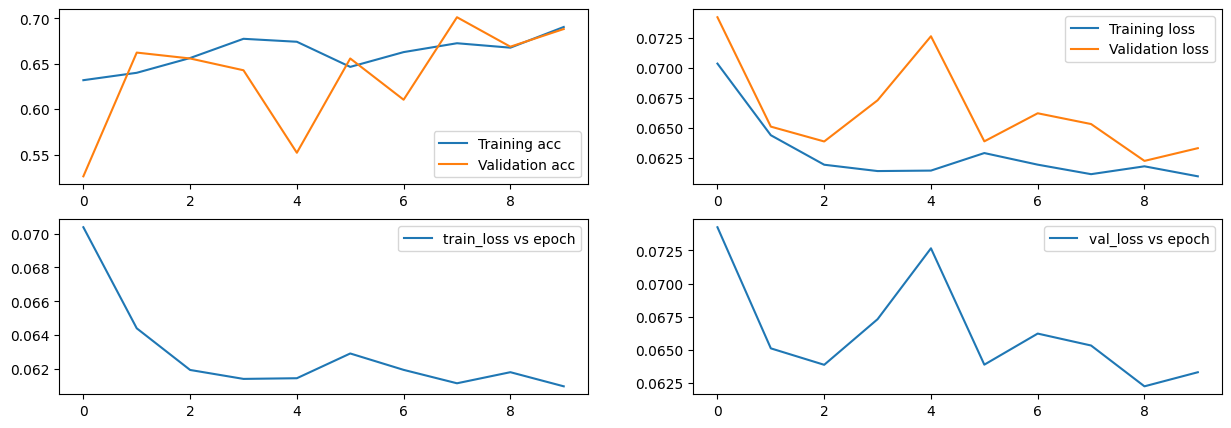

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(221)
plt.plot(hist['train_acc'], label='Training acc')
plt.plot(hist['val_acc'], label='Validation acc')
plt.legend()

plt.subplot(222)
plt.plot(hist['train_loss'], label='Training loss')
plt.plot(hist['val_loss'], label='Validation loss')
plt.legend()

plt.subplot(223)
plt.plot(hist['train_loss'], label='train_loss vs epoch')
plt.legend()

plt.subplot(224)
plt.plot(hist['val_loss'], label='val_loss vs epoch')
plt.legend()

# Prediction

In [26]:
predictions = model(X).detach().numpy()
results = np.where(predictions>0.35, 1, 0)
for i in range(5):
    print('%s => %d (expected %d)' % (X[i].tolist(), results[i], y[i]))

[6.0, 148.0, 72.0, 35.0, 0.0, 33.599998474121094, 0.6269999742507935, 50.0] => 1 (expected 1)
[1.0, 85.0, 66.0, 29.0, 0.0, 26.600000381469727, 0.35100001096725464, 31.0] => 0 (expected 0)
[8.0, 183.0, 64.0, 0.0, 0.0, 23.299999237060547, 0.671999990940094, 32.0] => 1 (expected 1)
[1.0, 89.0, 66.0, 23.0, 94.0, 28.100000381469727, 0.16699999570846558, 21.0] => 0 (expected 0)
[0.0, 137.0, 40.0, 35.0, 168.0, 43.099998474121094, 2.2880001068115234, 33.0] => 1 (expected 1)
